In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:3')
else:
    device = torch.device('cpu')
    
print(device)
device =  torch.device('cpu')

cpu


In [3]:
print(device)

cpu


In [4]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    
    def __len__(self):
        return len(self.X)

In [5]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,day_of_year,time_of_day,temp_mix03,temp_conv04,temp_initial00,obs_temp,input_obs,ice,snow,snowice
0,1,-1.220007,590.851292,-30.129462,-35.559056,0.0,0.8,1.757216,0.008038,36000000.0,...,1,2,5.379096,5.402835,5.431685,NaN,NaN,0.000000,0.0,0.0
1,2,-1.220007,590.851292,-30.129462,-35.559056,0.0,0.8,1.757216,0.008038,36000000.0,...,1,2,5.427976,5.429684,5.464454,NaN,NaN,0.000000,0.0,0.0
2,3,-1.220007,590.851292,-30.129462,-35.559056,0.0,0.8,1.757216,0.008038,36000000.0,...,1,2,5.458125,5.452260,5.481707,NaN,NaN,0.000000,0.0,0.0
3,4,-1.220007,590.851292,-30.129462,-35.559056,0.0,0.8,1.757216,0.008038,36000000.0,...,1,2,5.476137,5.452260,5.490656,NaN,NaN,0.000000,0.0,0.0
4,5,-1.220007,590.851292,-30.129462,-35.559056,0.0,0.8,1.757216,0.008038,36000000.0,...,1,2,5.486623,5.486623,5.495258,NaN,NaN,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3065970,21,3.860010,597.535984,25.682372,36.658380,0.0,0.8,6.709571,0.068577,36000000.0,...,363,0,0.478225,0.496168,0.478190,NaN,NaN,0.255083,0.0,0.0
3065971,22,3.860010,597.535984,25.682372,36.658380,0.0,0.8,6.709571,0.068577,36000000.0,...,363,0,0.461923,0.483696,0.461851,NaN,NaN,0.255083,0.0,0.0
3065972,23,3.860010,597.535984,25.682372,36.658380,0.0,0.8,6.709571,0.068577,36000000.0,...,363,0,0.456284,0.471708,0.456712,NaN,NaN,0.255083,0.0,0.0
3065973,24,3.860010,597.535984,25.682372,36.658380,0.0,0.8,6.709571,0.068577,36000000.0,...,363,0,0.001672,0.457236,0.456712,NaN,NaN,0.255083,0.0,0.0


In [6]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 122639
Number of training points: 1839575


# Normalizing Data

In [7]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [8]:
input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity' ,'temp_heat01']
output_columns = ['temp_diff02']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [9]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (1839575, 15), X_test: (1226400, 15)
y_train: (1839575, 1), y_test: (1226400, 1)


In [10]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

input_mean, input_std = train_mean[input_column_ix], train_std[input_column_ix]
output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

In [11]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(X_train, y_train)
test_dataset = DataGenerator(X_test, y_test)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [12]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [13]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500


optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [14]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=15, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [15]:
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

# mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
# std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

# mean_out = torch.tensor(output_mean).to(device)
# std_out = torch.tensor(output_std).to(device)
    
# def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
#     # de-normalise data
#     diff = diff * std_diff + mean_diff

#     # INPUT DATA FROM PREVIOUS MODULE
#     t = temp * std_temp + mean_temp # temperature profile from previous module output

#     # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     j = len(t)
#     y = torch.zeros((len(t), len(t)), dtype=torch.float64).to(device)

#     alpha = (dt/dx**2) * diff

#     az = - alpha # subdiagonal
#     bz = 2 * (1 + alpha) # diagonal
#     cz = - alpha # superdiagonal

#     bz[0] = 1
#     az[len(az)-2] = 0
#     bz[len(bz)-1] = 1
#     cz[0] = 0

#     az = az[1:,:]
#     cz = cz[:-1,:]

#     y = torch.diag(bz[:, 0])+torch.diag(az[:, 0],-1)+torch.diag(cz[:, 0],1) #slightly efficient way of computing the diagonal matrices
#     y[j-1, j-1] = 1
    
#     mn = torch.zeros_like(t)  
#     mn[0] = t[0]
#     mn[len(mn)-1] = t[len(t)-1]
    
#     mn[1:j-1] = alpha[1:j-1,0]*t[:j-2] + 2 * (1 - alpha[1:j-1,0])*t[1:j-1] + alpha[1:j-1,0]*t[1:j-1] #is be same as the loop
    
#     # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
#     proj = torch.linalg.solve(y, mn)

#     mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
#     proj = (proj-mean_out)/std_out

#     proj = proj.to(torch.double)
#     return proj

In [16]:
print(input_column_ix)
print(input_column_ix[13])
print(input_column_ix[5])
print(input_column_ix[:2])
print(input_column_ix[11])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
13
5
[0, 1]
16


In [17]:
mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [18]:
# diffusivity_true = torch.tensor(X_train[:,input_column_ix[13]], device=device).unsqueeze(1)
# temp_heat_true = torch.tensor(X_train[:,input_column_ix[14]], device=device)#.unsqueeze(1)
# mean_diff = torch.tensor(input_mean[input_column_ix[13]]).to(device)
# std_diff = torch.tensor(input_std[input_column_ix[13]]).to(device)
# print(mean_diff, std_diff)

# pred = implicit_diffusion(diff=diffusivity_true, 
#                           temp=temp_heat_true)

# print(torch.mean((pred-y_train)**2))

In [19]:
# time = 20
# # print(pred[25*time:25*(time+1)])
# # print(y_train[25*time:25*(time+1)])
# print((pred[25*time:25*(time+1)]-y_train[25*time:25*(time+1)]).abs())

In [20]:
# # test if the Crank-Nicholson scheme works

# temp = torch.rand(5,1).to(device)
# diff = torch.rand(5,1).to(device)
# print(temp), print(diff)
# implicit_diffusion(diff, temp, input_mean, input_std,
#                                  output_mean, output_std)

In [21]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y in iter(train_loader):
        x, y = x.to(device).float(), y.to(device).float()
        
        # get temperature input
        temp_input = x[:,14]
        
        optimizer.zero_grad()
        proj = model(x)
        
        pred = implicit_diffusion(proj, temp_input)
#         pred = pred.to(dtype=torch.float32)
        
#         print(pred.mean(), y.mean(), pred.std(), y.std())
        loss = criterion(pred, y)
        
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y in iter(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            temp_input = x[:,14] #* std + mean

            optimizer.zero_grad()
            proj = model(x)

            pred = implicit_diffusion(proj, temp_input)

            loss = criterion(pred, y)
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:50<14:09:00, 50.99s/it]

Epoch : 0, Train_loss: 0.006745448468743986, Test_loss: 0.007290090857035571


  5%|▌         | 51/1000 [31:01<10:40:28, 40.49s/it]

Epoch : 50, Train_loss: 0.005024232218768346, Test_loss: 0.008164587088914248


 10%|█         | 101/1000 [1:01:18<10:02:25, 40.21s/it]

Epoch : 100, Train_loss: 0.005023297204815722, Test_loss: 0.008290868536527194


 15%|█▌        | 151/1000 [1:31:25<9:26:07, 40.01s/it] 

Epoch : 150, Train_loss: 0.005009254741573544, Test_loss: 0.008219132633570858


 20%|██        | 201/1000 [2:01:24<8:53:25, 40.06s/it]

Epoch : 200, Train_loss: 0.005012210329068298, Test_loss: 0.008268047549215738


 25%|██▌       | 251/1000 [2:29:43<8:46:30, 42.18s/it]

Epoch : 250, Train_loss: 0.005027219290850158, Test_loss: 0.008156617628170654


 30%|███       | 301/1000 [3:00:36<7:51:48, 40.50s/it]

Epoch : 300, Train_loss: 0.0050093894900941375, Test_loss: 0.008139099802450617


 35%|███▌      | 351/1000 [3:30:54<7:21:57, 40.86s/it]

Epoch : 350, Train_loss: 0.005018954512691024, Test_loss: 0.008148948072959555


 40%|████      | 401/1000 [4:00:58<6:47:55, 40.86s/it]

Epoch : 400, Train_loss: 0.005030332944411582, Test_loss: 0.008184686205980682


 45%|████▌     | 451/1000 [4:23:31<3:52:45, 25.44s/it]

Epoch : 450, Train_loss: 0.004999415729790875, Test_loss: 0.0081612716219688


 50%|█████     | 501/1000 [4:42:25<3:32:04, 25.50s/it]

Epoch : 500, Train_loss: 0.00502276668969147, Test_loss: 0.008207109307259444


 55%|█████▌    | 551/1000 [5:01:12<3:10:05, 25.40s/it]

Epoch : 550, Train_loss: 0.00502236225052595, Test_loss: 0.00819369797338817


 60%|██████    | 601/1000 [5:20:07<2:50:44, 25.68s/it]

Epoch : 600, Train_loss: 0.0049754183772323735, Test_loss: 0.00821887630300728


 65%|██████▌   | 651/1000 [5:38:49<2:29:19, 25.67s/it]

Epoch : 650, Train_loss: 0.005045181782612496, Test_loss: 0.008182296785019567


 70%|███████   | 701/1000 [5:57:44<2:09:43, 26.03s/it]

Epoch : 700, Train_loss: 0.0050134092957191375, Test_loss: 0.00820848687516621


 75%|███████▌  | 751/1000 [6:16:26<1:45:56, 25.53s/it]

Epoch : 750, Train_loss: 0.005028390025773146, Test_loss: 0.008207147625799655


 80%|████████  | 801/1000 [6:35:26<1:26:46, 26.16s/it]

Epoch : 800, Train_loss: 0.005008736809616929, Test_loss: 0.008193324034886143


 85%|████████▌ | 851/1000 [6:54:12<1:03:07, 25.42s/it]

Epoch : 850, Train_loss: 0.005017931421120327, Test_loss: 0.008193605072938448


 90%|█████████ | 901/1000 [7:13:08<42:13, 25.59s/it]  

Epoch : 900, Train_loss: 0.005003622521927236, Test_loss: 0.008213915795132478


 95%|█████████▌| 951/1000 [7:31:56<20:45, 25.42s/it]

Epoch : 950, Train_loss: 0.005005375336939165, Test_loss: 0.008198308157999164


100%|██████████| 1000/1000 [7:50:16<00:00, 28.22s/it]


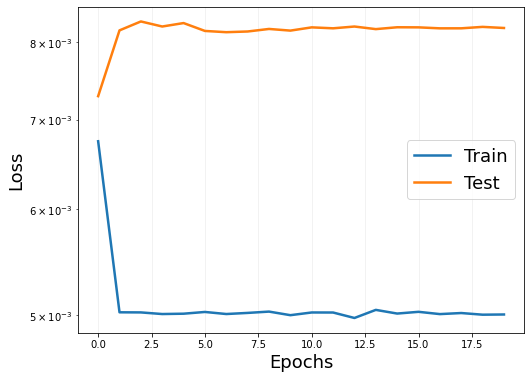

In [22]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [23]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y in iter(loader):
        x, y = x.to(device).float(), y.to(device).float()
        pred = model(x)
        
        temp_input = x[:,14]
        proj = model(x)
        pred = implicit_diffusion(proj, temp_input)        
        pred = pred.to(dtype=torch.float32)
        
#         print(torch.mean((pred-y)**2))
#         print(y.shape)
        
        y = y * std + mean
        pred = pred * std + mean
        
        y_.append(y)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    rmse_temp = rmse(y_, pred_)
    l2_error_temp = l2_error(y_, pred_)
    return rmse_temp, l2_error_temp

In [24]:
rmse_temp, l2_error_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Test Rmse of Temp: 0.5987123966827401
L2 Error  of Temp: 0.05843629116334848


In [25]:
rmse_temp, l2_error_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")
print(f"L2 Error  of Temp: {l2_error_temp}")

Train Rmse of Temp: 0.4678005875868935
L2 Error  of Temp: 0.048724301194336794


# Saving Model

In [26]:
PATH = f"./saved_models/heat_diffusion_model_time.pth"
torch.save(model.state_dict(), PATH)

In [27]:
output_mean

array([6.96297147])